In [1]:
import torch
from transformer_lens import HookedTransformer
import numpy as np

# Load Dictionaries

In [16]:
import pickle
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self, activation_size, n_dict_components, t_type=torch.float32, l1_coef=0.0):
        super(AutoEncoder, self).__init__()
        self.decoder = nn.Linear(n_dict_components, activation_size, bias=False)
        # Initialize the decoder weights orthogonally
        nn.init.orthogonal_(self.decoder.weight)
        self.decoder = self.decoder.to(t_type)

        self.encoder = nn.Sequential(nn.Linear(activation_size, n_dict_components).to(t_type), nn.ReLU())
        self.l1_coef = l1_coef
        self.activation_size = activation_size
        self.n_dict_components = n_dict_components

    def forward(self, x):
        c = self.encoder(x)
        # Apply unit norm constraint to the decoder weights
        self.decoder.weight.data = nn.functional.normalize(self.decoder.weight.data, dim=0)

        x_hat = self.decoder(c)
        return x_hat, c

    @property
    def device(self):
        return next(self.parameters()).device
    

layer = 2
setting = "residual"
# setting = "mlp"
# model_name = "EleutherAI/pythia-1.4b-deduped"
model_name = "EleutherAI/pythia-70m-deduped"
# filename = r'/root/sparse_coding/autoencoders4.pkl'
# filename = r'/root/sparse_coding/auto_encoders.pkl'
# filename = r'outputs/20230706-225337/auto_encoders_15.pkl'
# filename = r'/root/pythia70m_layer2_residual_tied_.pkl'
filename = f'/workspace/sparse_coding/outputs/20230729-101748/0/auto_encoders_2.pkl'
# change this Julie

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
else:
    raise NotImplementedError

# Load in the Pythia model w/ transformer lens
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)
if(setting == "residual"):
    neurons = model.cfg.d_model
elif(setting == "mlp"):
    neurons = model.cfg.d_mlp
else:
    raise NotImplementedError

# Load the pickle file
with open(filename, 'rb') as file:
    autoencoders = pickle.load(file)

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


In [17]:
l1_index = -1
dictionaries = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders[l1_index]]

In [18]:
for d in dictionaries:
    print(d.shape)

torch.Size([1024, 512])
torch.Size([2048, 512])
torch.Size([4096, 512])
torch.Size([8192, 512])
torch.Size([16384, 512])
torch.Size([32768, 512])


In [19]:
len(autoencoders)

1

In [20]:
dict_index = 2
smaller_dict, larger_dict = dictionaries[dict_index], dictionaries[dict_index+1]
smaller_auto_encoder, larger_auto_encoder = autoencoders[l1_index][dict_index], autoencoders[l1_index][dict_index+1]

# MCS

In [21]:
#Dictionary Comparison
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
smaller_dict_features, _ = smaller_dict.shape
larger_dict_features, _ = larger_dict.shape
larger_dict = larger_dict.to(device)
# Hungary algorithm
from scipy.optimize import linear_sum_assignment
# Calculate all cosine similarities and store in a 2D array
cos_sims = np.zeros((smaller_dict_features, larger_dict_features))
for idx, vector in enumerate(smaller_dict):
    cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), larger_dict, dim=1).cpu().numpy()
# Convert to a minimization problem
cos_sims = 1 - cos_sims
# Use the Hungarian algorithm to solve the assignment problem
row_ind, col_ind = linear_sum_assignment(cos_sims)
# Retrieve the max cosine similarities and corresponding indices
max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]

print(max_cosine_similarities)

[0.44579208 0.16210654 0.47205484 ... 0.18359646 0.3868705  0.17432681]


631


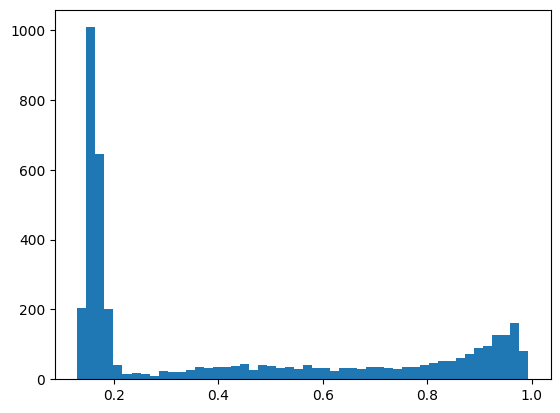

In [22]:
# Get the indices of the max cosine similarities in descending order
max_indices = np.argsort(max_cosine_similarities)[::-1]
max_cosine_similarities[max_indices][:20]
print((max_cosine_similarities > .9).sum())
# Plot histogram of max_cosine_similarities
import matplotlib.pyplot as plt
plt.hist(max_cosine_similarities, bins=50)
plt.show()

# Model activations & Dictionary Activations

In [23]:
# Downnload dataset
from datasets import Dataset, load_dataset
dataset_name = "NeelNanda/pile-10k"
token_amount=64
dataset = load_dataset(dataset_name, split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

Found cached dataset parquet (/root/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9620 [00:00<?, ? examples/s]

In [25]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange

datapoints = dataset.num_rows
batch_size = 32
neuron_activations = torch.zeros((datapoints*token_amount, neurons))
dictionary_activations = torch.zeros((datapoints*token_amount, smaller_dict_features))
smaller_auto_encoder = smaller_auto_encoder.to(device)

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        _, cache = model.run_with_cache(batch.to(device))
        batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
        neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations.cpu()
        reconstruction, batched_dictionary_activations = smaller_auto_encoder(batched_neuron_activations)
        dictionary_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations.cpu()

  0%|          | 0/301 [00:00<?, ?it/s]

## Neuron Sparsity per Feature by Activations

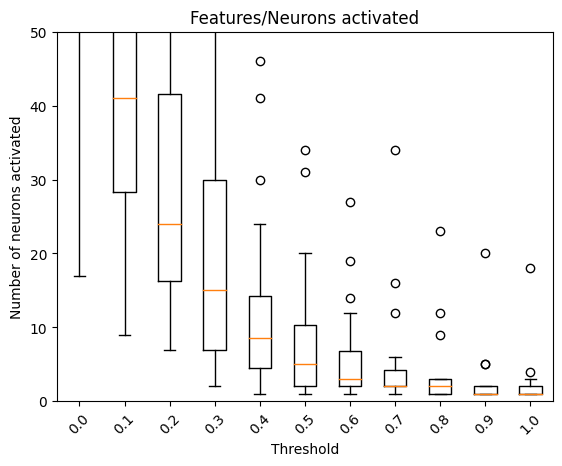

In [26]:
# Find corresponding neurons activations between pythia & autoencoder
# Get the activations for the best dict features
thresholds = [round(0.1*x,1) for x in range(11)]
all_activated_neurons = []
for threshold in thresholds:
    current_activated_neurons = []
    for x in range(20):
        best_feature = max_indices[x]
        best_feature_activations = dictionary_activations[:, best_feature]
        # Sort the features by activation, get the indices
        nonzero_indices = torch.argsort(best_feature_activations, descending=True)
        sorted_indices = nonzero_indices[:10]
        t = (neuron_activations[sorted_indices, :] > threshold)
        # ( And across the first dim)
        t = t.all(dim=0)
        neurons_activated = t.sum()
        current_activated_neurons.append(neurons_activated)
        # print(f"Feature {x} is active for {t.sum()} neurons")
    all_activated_neurons.append(current_activated_neurons)
# Plot boxplot w/ plotly

plt.boxplot(all_activated_neurons, labels=thresholds)
plt.xticks(rotation=45)
plt.xlabel("Threshold")
plt.ylabel("Number of neurons activated")
plt.title("Features/Neurons activated")
plt.ylim(0, 50)
plt.show()

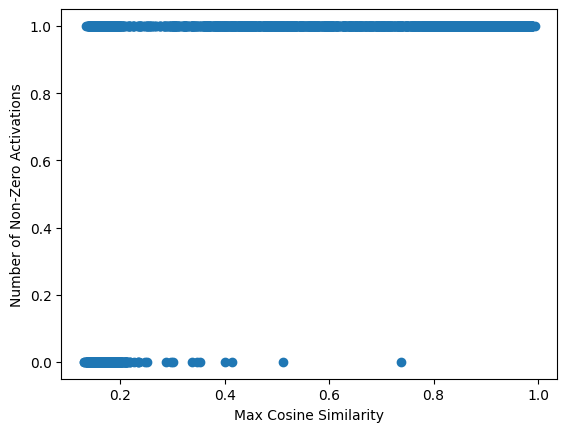

In [27]:
# Find number of non-zero activations for each feature in the dictionary
nonzero_activations = dictionary_activations.count_nonzero(dim=0)
# clip to 1
nonzero_activations = nonzero_activations.clamp(max=1)
# plot against the max cosine similarities
# plt.hist(nonzero_activations.cpu().numpy(), bins=100)
plt.scatter(max_cosine_similarities, nonzero_activations.cpu().numpy())
# x-axis is the max cosine similarity
# y-axis is the number of non-zero activations
# now setting x-axis
plt.xlabel("Max Cosine Similarity")
plt.ylabel("Number of Non-Zero Activations")
plt.show()

# Feature Activation Analysis

In [29]:
from circuitsvis.activations import text_neuron_activations
# Get the activations for the best dict features
def get_feature_datapoints(feature_index, dictionary_activations, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        min_value = torch.min(best_feature_activations)
        max_value = torch.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    datapoint_indices =[np.unravel_index(i, (datapoints, token_amount)) for i in found_indices]
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(model.tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        text = model.tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list

def get_neuron_activation(token, feature, model):
    with torch.no_grad():
        _, cache = model.run_with_cache(token.to(model.cfg.device))
        neuron_act_batch = cache[cache_name]
        _, act = smaller_auto_encoder(neuron_act_batch)
    return act[0, :, feature].tolist()

def ablate_text(text, feature, model, setting="plot"):
    if isinstance(text, str):
        text = [text]
    display_text_list = []
    activation_list = []
    for t in text:
        # Convert text into tokens
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            tokens = model.to_tokens(t, prepend_bos=False)
        else: # t equals tokens
            tokens = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        seq_size = tokens.shape[1]
        if(seq_size == 1): # If the text is a single token, we can't ablate it
            continue
        original = get_neuron_activation(tokens, feature, model)[-1]
        changed_activations = torch.zeros(seq_size, device=device).cpu()
        for i in range(seq_size):
            # Remove the i'th token from the input
            ablated_tokens = torch.cat((tokens[:,:i], tokens[:,i+1:]), dim=1)
            changed_activations[i] += get_neuron_activation(ablated_tokens, feature, model)[-1]
        changed_activations -= original
        display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        activation_list += changed_activations.tolist() + [0.0]
    activation_list = torch.tensor(activation_list).reshape(-1,1,1)
    if setting == "plot":
        return text_neuron_activations(tokens=display_text_list, activations=activation_list)
    else:
        return display_text_list, activation_list
def visualize_text(text, feature, model, setting="plot", max_activation = None):
    if isinstance(text, str):
        text = [text]
    if isinstance(feature, int):
        feature = [feature]
    display_text_list = []
    act_list = []
    for t in text:
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            token = model.to_tokens(t, prepend_bos=False)
        else: # t are tokens
            token = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        for f in feature:
            display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            act_list += get_neuron_activation(token, f, model) + [0.0]
    act_list = torch.tensor(act_list).reshape(-1,1,1)
    if(max_activation is not None):
        act_list = torch.clamp(act_list, max=max_activation)
    return text_neuron_activations(tokens=display_text_list, activations=act_list)


In [30]:
# Ablate the feature direction of the tokens
# token_list is a list of tokens, convert to tensor of shape (batch_size, seq_len)
from einops import rearrange
def ablate_feature_direction(tokens, feature, model, autoencoder):
    def mlp_ablation_hook(value, hook):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        _, act = autoencoder(int_val)
        feature_to_ablate = feature # TODO: bring this out of the function

        # Subtract value with feature direction*act_of_feature
        feature_direction = torch.outer(act[:, feature_to_ablate].squeeze(), autoencoder.decoder.weight[:, feature_to_ablate].squeeze())
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value -= feature_direction
        return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name,
            mlp_ablation_hook
            )]
        ) #returns all the logits 



def add_feature_direction(tokens, feature, model, autoencoder, amount):
    def mlp_add_hook(value, hook):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        _, act = autoencoder(int_val)
        feature_to_ablate = feature # TODO: bring this out of the function

        # Add value with feature direction*act_of_feature
        #feature_direction = torch.outer(act[:, feature_to_ablate].squeeze(), autoencoder.decoder.weight[:, feature_to_ablate].squeeze())
        feature_direction = autoencoder.decoder.weight[:, feature_to_ablate].squeeze()

        # batch, seq_len, hidden_size = value.shape
        # feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value += amount * feature_direction
        return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name,
            mlp_add_hook
            )]
        ) #returns all the logits 



def visualize_logit_diff(text, features=None, setting="true_tokens", verbose=False):
    features = best_feature

    if features==None:
        features = torch.tensor([best_feature])
    if isinstance(features, int):
        features = torch.tensor([features])
    if isinstance(features, list):
        features = torch.tensor(features)
    if isinstance(text, str):
        text = [text]
    text_list = []
    logit_list = []
    for t in text:
        tokens = model.to_tokens(t, prepend_bos=False)
        with torch.no_grad():
            original_logits = model(tokens).log_softmax(-1).cpu()
            ablated_logits = ablate_feature_direction(tokens, features, model, smaller_auto_encoder).log_softmax(-1).cpu()
        diff_logits = ablated_logits  - original_logits# ablated > original -> negative diff
        tokens = tokens.cpu()
        if setting == "true_tokens":
            split_text = model.to_str_tokens(t, prepend_bos=False)
            gather_tokens = rearrange(tokens[:,1:], "b s -> b s 1") # TODO: verify this is correct
            # Gather the logits for the true tokens
            diff = rearrange(diff_logits[:, :-1].gather(-1,gather_tokens), "b s n -> (b s n)")
        elif setting == "max":
            # Negate the diff_logits to see which tokens have the largest effect on the neuron
            val, ind = (-1*diff_logits).max(-1)
            diff = rearrange(val[:, :-1], "b s -> (b s)")
            diff*= -1 # Negate the values gathered
            split_text = model.to_str_tokens(ind, prepend_bos=False)
            gather_tokens = rearrange(ind[:,1:], "1 s -> 1 s 1")
        split_text = split_text[1:] # Remove the first token since we're not predicting it
        if(verbose):
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            orig = rearrange(original_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            ablated = rearrange(ablated_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            logit_list += orig.tolist() + [0.0]
            logit_list += ablated.tolist() + [0.0]
        text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        logit_list += diff.tolist() + [0.0]
    logit_list = torch.tensor(logit_list).reshape(-1,1,1)
    if verbose:
        print(f"Max & Min logit-diff: {logit_list.max().item():.2f} & {logit_list.min().item():.2f}")
    return text_neuron_activations(tokens=text_list, activations=logit_list)

In [31]:
#GENERATES TEXT

#To do needs to include smth about ablating a feature

from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch.nn.functional as F
import random as random 


def generate_text(input_text, length, feature, amount):
    generated_text = input_text
    
    input_ids = model.tokenizer.encode(input_text, return_tensors='pt')
    
    #token by token
    for _ in range(length):  
        # Get the model's predictions
        with torch.no_grad():
            #outputs = model(input_ids)
            #print(outputs)

            outputs = add_feature_direction(model.tokenizer.encode(input_text, return_tensors='pt'), feature, model, smaller_auto_encoder, amount)	

            
            logits = outputs.log_softmax(-1).cpu()

        logits = logits[0, -1, :]

        

        #teehee delete this here we could do a func on it 
        #logits = logits + random.randint(0, 100)/1 
        
        

        # Sample the next token
        next_token_id = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)

        # temperature = 1.0  # Adjust this value to increase or decrease randomness
        # next_token_id = torch.multivariate_normal(F.softmax(logits / temperature, dim=-1), num_samples=1)


        # Decode the token and add it to the generated text
        next_token = model.tokenizer.decode(next_token_id)
        generated_text += next_token

        # Update the input ids
        input_ids = torch.cat([input_ids, next_token_id.unsqueeze(0)], dim=-1)  # The new token must be unsqueezed to have the correct shape
        

    return generated_text


#RUN THIS, RUN WITH ANY LOGITS, INPUT TEXT, LENGTH YOU LIKE 
input_text = "we're no strangers to love" 

#EDIT THIS TO ANY
for amt in range(0, 10, 1):
    print(generate_text(input_text, 50, 1605, amt/3))

#hihi





we're no strangers to love, games but China,. you or me movies,, the all me or or to other her us.]." or someone myself,... the when you another a the you us. to us
. here ouryou in: you. sports,
we're no strangers to love either objects young you when or us the him." them him you me and another them a the mism their people them their./ either you a
 enjoying each their their you someone or their the Evil ' people your you secrecy A — her Claire Brazil
we're no strangers to love fict rather, your these and to.
, a you him as," and an and any you or, or lone white you or you. or the you...". or people, less-- him them. one us or our one such. them
we're no strangers to love her. me old eng," automotive Leo one us her.. ' the the.'; YOU boy, these her blood sup ours you me a for and. and per. to.. your you. anything your Ab,. you and themselves and?
we're no strangers to love without their who cocaine. my You a these Django us than with., seeing their the strangers you each,!". people...

We'll look at feature 52, which has an MCS of 0.96 (w/ perfect MCS at 1.0). To get a feel for the feature, Let's plot the feature activation.

In [32]:
# dataset["input_ids"]
tokens_dataset = [torch.tensor(x["input_ids"]) for x in dataset]    
tokens_dataset = torch.stack(tokens_dataset)
tokens_dataset = rearrange(tokens_dataset, 't s-> (t s)')
tokens_dataset.shape, dictionary_activations.shape
size = 100000
sub_tokens = tokens_dataset[:size]
sub_activations = dictionary_activations[:size]
import torch
threshold = 2.0
def get_unique_tokens_torch_efficient(dictionary_activations, tokens_dataset):
    # Convert tokens_dataset to a torch tensor for efficient indexing
    tokens_dataset = torch.tensor(tokens_dataset)
    
    # Initialize an empty dictionary to store counts for each feature
    feature_counts = torch.zeros(dictionary_activations.size(1))

    # Apply operations feature by feature
    for feature_idx in range(dictionary_activations.size(1)):
        # Get the activations for the current feature
        feature_activations = dictionary_activations[:, feature_idx]
        
        # Find the indices of the non-zero activations
        # nonzero_indices = torch.nonzero(feature_activations, as_tuple=True)[0]
        nonzero_indices = torch.nonzero(feature_activations > threshold, as_tuple=True)[0]
        
        # Use these indices to find the corresponding tokens
        feature_tokens = tokens_dataset[nonzero_indices]
        
        # Count the unique tokens
        unique_tokens = torch.unique(feature_tokens)
        feature_counts[feature_idx] = unique_tokens.numel()

    return feature_counts

feature_counts = get_unique_tokens_torch_efficient(sub_activations, sub_tokens)

(feature_counts[max_indices.copy()] == 1).nonzero(), feature_counts[max_indices.copy()].topk(10)

/tmp/ipykernel_4080/194007354.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens_dataset = torch.tensor(tokens_dataset)


(tensor([[  11],
         [  21],
         [  23],
         [  34],
         [  44],
         [ 102],
         [ 118],
         [ 120],
         [ 126],
         [ 135],
         [ 143],
         [ 146],
         [ 160],
         [ 180],
         [ 188],
         [ 190],
         [ 191],
         [ 192],
         [ 197],
         [ 202],
         [ 209],
         [ 223],
         [ 225],
         [ 226],
         [ 227],
         [ 235],
         [ 241],
         [ 242],
         [ 258],
         [ 260],
         [ 282],
         [ 290],
         [ 297],
         [ 302],
         [ 325],
         [ 335],
         [ 337],
         [ 354],
         [ 356],
         [ 359],
         [ 363],
         [ 365],
         [ 367],
         [ 387],
         [ 402],
         [ 409],
         [ 427],
         [ 430],
         [ 432],
         [ 457],
         [ 464],
         [ 465],
         [ 473],
         [ 484],
         [ 490],
         [ 498],
         [ 521],
         [ 530],
         [ 546

# Data Centric Viewpoint

In [33]:
# Go through datapoints & see if the features that activate on them make sense.
d_point = 3
text = tokens_dataset[d_point]
data_ind, sequence_pos = np.unravel_index(d_point, (datapoints, token_amount))
feature_val, feature_ind = dictionary_activations[d_point].topk(10)
data_ind = int(data_ind)
sequence_pos = int(sequence_pos)
full_tok = torch.tensor(dataset[data_ind]["input_ids"])
full_text = []
full_text.append(model.tokenizer.decode(full_tok))
visualize_text(full_text, feature_ind, model, setting="plot")

In [34]:
(feature_counts[max_indices.copy()] == 1).nonzero(), feature_counts[max_indices.copy()].topk(50)

(tensor([[  11],
         [  21],
         [  23],
         [  34],
         [  44],
         [ 102],
         [ 118],
         [ 120],
         [ 126],
         [ 135],
         [ 143],
         [ 146],
         [ 160],
         [ 180],
         [ 188],
         [ 190],
         [ 191],
         [ 192],
         [ 197],
         [ 202],
         [ 209],
         [ 223],
         [ 225],
         [ 226],
         [ 227],
         [ 235],
         [ 241],
         [ 242],
         [ 258],
         [ 260],
         [ 282],
         [ 290],
         [ 297],
         [ 302],
         [ 325],
         [ 335],
         [ 337],
         [ 354],
         [ 356],
         [ 359],
         [ 363],
         [ 365],
         [ 367],
         [ 387],
         [ 402],
         [ 409],
         [ 427],
         [ 430],
         [ 432],
         [ 457],
         [ 464],
         [ 465],
         [ 473],
         [ 484],
         [ 490],
         [ 498],
         [ 521],
         [ 530],
         [ 546

In [35]:
# sentences = ['he was rude and mean', "evil bully", " illegal vandalism", " ruthless kill"]
# whitelist = dict()
# for t in sentences:
#     split_text = model.to_str_tokens(t, prepend_bos=False)
#     token = model.to_tokens(t, prepend_bos=False)
#     _, cache = model.run_with_cache(token.to(model.cfg.device))
#     neuron_act_batch = cache[cache_name]
#     _, act = smaller_auto_encoder(neuron_act_batch)
#     features = act[0, -1, :].topk(50).indices
#     values = act[0, -1, :].topk(50).values
#     blacklist = [1717, 1828, 1291, 1998, 1284, 1415, 1820, 4, 1672, 401, 1752, 2028, 1154, 1971, 1746, 1454, 636, 1287, 1536, 1220, 509, 1156, 1602, 1375, 1129, 413, 1817, 1599, 1724, 1951, 648, 741, 962, 1270, 949, 453, 57, 900, 1394, 1619, 322, 814, 2043, 182, 1474, 1469, 2031, 300, 1576, 1225, 2041, 706, 1614, 177, 814, 133, 1515, 1886, 31]
#     for feature, value in zip(features, values):
#         if feature not in blacklist:
#             if feature in whitelist:
#                 whitelist[feature.item()] += value.item()
#             else:
#                 whitelist[feature.item()] = round(value.item(), 4)
# print(sorted(list(whitelist.items()), key=lambda x:x[1], reverse=True))


#Adam new version
sentences = ['son of a bitch', "what the fuck", "you are a slut", " shithead"]
outlier_filter = ['\newline...\newline...']
# blacklist = [1717, 1828, 1291, 1998, 1284, 1415, 1820, 4, 1672, 401, 1752, 2028, 1154, 1971, 1746, 1454, 636, 1287, 1536, 1220, 509, 1156, 1602, 1375, 1129, 413, 1817, 1599, 1724, 1951, 648, 741, 962, 1270, 949, 453, 57, 900, 1394, 1619, 322, 814, 2043, 182, 1474, 1469, 2031, 300, 1576, 1225, 2041, 706, 1614, 177, 814, 133, 1515, 1886, 31]
blacklist = []
whitelist = dict()
for t in sentences:
    split_text = model.to_str_tokens(t, prepend_bos=False)
    token = model.to_tokens(t, prepend_bos=False)
    _, cache = model.run_with_cache(token.to(model.cfg.device))
    neuron_act_batch = cache[cache_name]
    _, act = smaller_auto_encoder(neuron_act_batch)
    features = act[0, -1, :].topk(100).indices
    values = act[0, -1, :].topk(100).values
    
    for feature, value in zip(features, values):
        if feature not in blacklist:
            if feature in whitelist:
                whitelist[feature.item()] += value.item()
            else:
                whitelist[feature.item()] = round(value.item(), 4)
candidates = sorted(list(whitelist.items()), key=lambda x:x[1], reverse=True)
final_output = list()
for feature, value in candidates:
    split_text = model.to_str_tokens(outlier_filter, prepend_bos=False)
    token = model.to_tokens(outlier_filter, prepend_bos=False)
    _, cache = model.run_with_cache(token.to(model.cfg.device))
    neuron_act_batch = cache[cache_name]
    _, act = smaller_auto_encoder(neuron_act_batch)
    if act[0, 0, feature] < 2:
        final_output.append((feature, value))
print(final_output[:20])

[(858, 3.4884), (306, 1.9837), (1746, 1.4728), (1005, 1.4562), (1540, 1.3844), (87, 1.3085), (1174, 1.2541), (545, 1.2519), (2098, 1.0869), (159, 0.952), (3908, 0.9453), (3449, 0.8956), (3857, 0.8952), (573, 0.8869), (3419, 0.8648), (1455, 0.853), (521, 0.8338), (3572, 0.7994), (2302, 0.7915), (365, 0.7692)]


In [36]:
N = 11
best_feature = int(max_indices[N])
print("feat_index=", best_feature)
best_feature = 1605#feature num 10

print("bias:", smaller_auto_encoder.encoder_bias.detach().cpu().numpy()[best_feature])
print(f"Max feature index: {N}")
print(f"MCS: {max_cosine_similarities[best_feature]}")
# text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="uniform")
text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="max")
visualize_text(full_text, best_feature, model, setting="plot")
# visualize_text(text_list, best_feature, model, setting="plot")

feat_index= 2940


AttributeError: 'AutoEncoder' object has no attribute 'encoder_bias'

In [ ]:
visualize_logit_diff(full_text, best_feature)

In [ ]:
with torch.no_grad():
    bad_ind = (model.W_U.norm(dim=0) > 20)
    feature_direction = smaller_dict[best_feature].to(device)
    # residual_direction = torch.matmul(feature_direction, model.W_out[layer]) # Add bias
    # feature_direction = model.ln_final(feature_direction)
    logits = torch.matmul(feature_direction, model.W_U).cpu()
    # logits = model.W_U(residual_direction).cpu()
# Don't include bad indices
logits[bad_ind] = -1000
topk_values, topk_indices = torch.topk(logits, 20)
top_text = model.to_str_tokens(topk_indices)
print(f"{top_text}")
print(topk_values)

In [ ]:
ablate_text(text_list, best_feature, model, setting="plot")

In [ ]:
# Instead of top-k examples, just random samples from non-zero values
text_list, full_text, _, _ = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="uniform", k=10)
visualize_text(full_text, best_feature, model, setting="plot")

In [ ]:
visualize_text(text_list, best_feature, model, setting="plot")

In [ ]:
def prepend_all_tokens_and_get_feature_activation(model, minimal_activating_example, feature, setting="prepend"):
    tokens = model.to_tokens(minimal_activating_example, prepend_bos=False)

    # Run through every number up to vocab size
    vocab_size = model.cfg.d_vocab
    batch_size = 256 # Define your desired batch size

    dollar_feature_activations = torch.zeros(vocab_size)
    for start in range(0, vocab_size, batch_size):
        end = min(start + batch_size, vocab_size)

        token_prep = torch.arange(start, end).to(device)
        token_prep = token_prep.unsqueeze(1)  # Add a dimension for concatenation

        # 1. Prepend to the tokens
        if setting == "prepend":
            tokens_catted = torch.cat((token_prep, tokens.repeat(end - start, 1)), dim=1).long()
        elif setting == "append":
            tokens_catted = torch.cat((tokens.repeat(end - start, 1), token_prep), dim=1).long()
        else:
            raise ValueError(f"Unknown setting: {setting}")

        # 2. Run through the model
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens_catted.to(device))
            neuron_act_batch = cache[cache_name]
            _, act = smaller_auto_encoder(neuron_act_batch)

        # 3. Get the feature
        dollar_feature_activations[start:end] = act[:, -1, feature].cpu().squeeze()

    k = 20
    k_increasing_val, k_increasing_ind = dollar_feature_activations.topk(k)
    k_decreasing_val, k_decreasing_ind = dollar_feature_activations.topk(k, largest=False)
    if(setting == "prepend"):
        print(f"[token]{minimal_activating_example}")
    elif(setting == "append"):
        print(f"{minimal_activating_example}[token]")
    else:
        raise ValueError(f"Unknown setting: {setting}")
    # Print indices converted to tokens
    print(f"Top-{k} increasing: {model.to_str_tokens(k_increasing_ind)}")
    # Print values
    print(f"Top-{k} increasing: {[f'{val:.2f}' for val in k_increasing_val]}")
    print(f"Top-{k} decreasing: {model.to_str_tokens(k_decreasing_ind)}")
    print(f"Top-{k} decreasing: {[f'{val:.2f}' for val in k_decreasing_val]}")
    print(f"Number of 0 activations: {torch.sum(dollar_feature_activations == 0)}")
    if(setting == "prepend"):
        best_text = "".join(model.to_str_tokens(dollar_feature_activations.argmax()) + [minimal_activating_example])
    else:
        best_text = "".join([minimal_activating_example] + model.to_str_tokens(dollar_feature_activations.argmax()))
    return best_text

best_text = ""
for x in range(3):
    # best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " for all $", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")

In [ ]:
best_text = ","
for x in range(3):
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")

In [ ]:
prepend_all_tokens_and_get_feature_activation(model, " x", best_feature, setting="prepend")
prepend_all_tokens_and_get_feature_activation(model, " let", best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")

In [ ]:
text_list = [
    " $",
    " for $",
    " integral $",
    " hey $",
    " integral for $",
    " sold for $",
    " for all $",
    " sold for all $",
    " profit for all $",
    " \n for all $",
    " {] for all $",
]
text_list = [
    " The bugs and trees went up. The bugs",
    " The bugs, bees, and trees went up. The bugs, bees,",
    " The bugs, bees, and trees went up. The bugs, bees, and trees went down. The bugs, bees,",
    " He counted 1, 2, 3!",
    " He counted 1, 2, 3!",
]
text_list = [
    "The picture is as clear as black and white.",
    "Could you pass the salt and pepper, please?",
    "This job is our bread and butter, we can't afford to lose it.",
    "We need to consider the pros and cons before making a decision.",
    "It's a process of trial and error until we find the right solution.",
    "When you flip a coin, do you choose heads or tails?",
    "We have to act fast, it's now or never.",
    "The concert was a mix of jazz and rock and roll.",
    "In England, it's traditional to have fish and chips on Fridays.",
    "The bride and groom looked absolutely stunning.",
]

visualize_text(text_list, best_feature, model, setting="plot")

In [ ]:
ablate_text(text_list, best_feature, model, setting="plot")

Beyond the first token, this doesn't fit within the hypothesis, though may be OOD. A check (for the future) would be to constrain by the model's next word prediction (and maybe do direct soft prompts).

## Comparing to the Neuron Basis
Does this feature net us anything over using the normal neuron basis? If this is only learning a monosemantic feature, then that's pretty lame! 

We can first check how many neurons activate above a threshold for the top-10 feature activating examples (ie a neuron must activate above threshold for all 10 examples)

In [ ]:
# Neurons that fire for this feature
# Find corresponding neurons activations between pythia & autoencoder
# Get the activations for the best dict features
len_threshold = 11
thresholds = [round(0.1*x,1) for x in range(len_threshold)]
current_activated_neurons = np.zeros(len_threshold)
for idx, threshold in enumerate(thresholds):
    best_feature_activations = dictionary_activations[:, best_feature]
    # Sort the features by activation, get the indices
    nonzero_indices = torch.argsort(best_feature_activations, descending=True)
    sorted_indices = nonzero_indices[:10]
    t = (neuron_activations[sorted_indices, :] > threshold)
    # And across the first dim)
    t = t.all(dim=0)
    neurons_activated = t.sum()
    current_activated_neurons[idx] = neurons_activated
    print(f"Threshold: {threshold}, Neurons activated: {neurons_activated}")
# Plot boxplot w/ plotly
plt.scatter(thresholds, current_activated_neurons)
plt.xticks(rotation=45)
plt.xlabel("Threshold")
plt.ylabel("Number of neurons activated")
plt.title("Features/Neurons activated")
# plt.ylim(0, 10)
plt.show()

Notably it's a lot of neurons for above 0, but then goes to 3 for 0.5. However, we don't really know the statistics of neuron activations. Maybe some neuron's entire range is very tiny? So, we can see how many neurons are above a threshold determined by that neuron's quantiles.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

len_threshold = 11
thresholds = [round(0.1 * x, 1) for x in range(len_threshold)]
thresholds[-1] = 0.99
current_activated_neurons = np.zeros(len_threshold)

# Find corresponding neurons activations between pythia & autoencoder
best_feature_activations = dictionary_activations[:, best_feature]

# Sort the features by activation and get the indices
nonzero_indices = torch.argsort(best_feature_activations, descending=True)
sorted_indices = nonzero_indices[:11]

neuron_test = neuron_activations[:50000, :]
neuron_test = neuron_test.to(device)
thresholds_t = torch.tensor(thresholds).to(device)
neuron_activations = neuron_activations.to(device)
# above_quantile = neuron_test[above_zero_indices].quantile(0.5, dim=0)

# Calculate the quantiles for each neuron's activation range
quantiles = torch.quantile(neuron_test, thresholds_t, dim=0)

for idx, threshold in enumerate(quantiles):
    # Determine which neurons activate above their specific quantile
    above_threshold_mask = neuron_activations[sorted_indices, :] > threshold.unsqueeze(0)
    neurons_activated = above_threshold_mask.float().mean(dim=0).count_nonzero()
    current_activated_neurons[idx] = neurons_activated
    print(f"Quantile: {thresholds[idx]}, Neurons activated: {neurons_activated}")

# Plot scatter plot
plt.scatter(thresholds, current_activated_neurons)
plt.xticks(rotation=45)
plt.xlabel("Quantile")
plt.ylabel("Number of neurons activated")
plt.title("Features/Neurons activated")
# plt.ylim(0, 200)
plt.show()

Here, 80 neurons are activating in above their top 1% of activations.

Another way is to look at the decoder of the dictionary & see the weights effect on neurons since it's just a linear layer. Additionally, I'll multiply by the max-activation of that feature to show the scale of the effect on the neurons.

In [ ]:
# Check features non-zero weights in decoder
# Plot a histogram of the weights
max_activation = dictionary_activations[:, best_feature].max()
weights = smaller_dict[best_feature]
plt.hist(weights, bins=100)
plt.show()

In [ ]:
(weights).topk(20, largest=False)

So a few datapoints to indicate somewhere between 3 & 80 neurons, maybe several hundred depending on how you interpret the 

In [ ]:
# Logit lens
# Multiply feature direction by W_out[layer]
# Then by W_U
for n in range(52, 53):
    b_feature = max_indices[n]
    with torch.no_grad():
        feature_direction = smaller_dict[b_feature].to(device)
        residual_direction = torch.matmul(feature_direction, model.W_out[layer]) # Add bias
        # residual_direction = model.ln_final(residual_direction)
        logits = torch.matmul(residual_direction, model.W_U).cpu()
    topk_values, topk_indices = torch.topk(logits, 10)
    top_text = model.to_str_tokens(topk_indices)
    print(f"Feature {n}: {top_text}")
# print(topk_values)

In [ ]:
# import circuitsvis
# text = full_text
# features = best_feature

# if features==None:
#     features = torch.tensor([best_feature])
# if isinstance(features, int):
#     features = torch.tensor([features])
# if isinstance(features, list):
#     features = torch.tensor(features)
# if isinstance(text, str):
#     text = [text]
# text_list = []
# logit_list = []
# for t in text:
#     tokens = model.to_tokens(t, prepend_bos=False)
#     with torch.no_grad():
#         original_logits = model(tokens).log_softmax(-1).cpu()
#         ablated_logits = ablate_feature_direction(tokens, features, model, smaller_auto_encoder).log_softmax(-1).cpu()
#     # diff_logits = ablated_logits  - original_logits# ablated > original -> negative diff
#     diff_logits =   original_logits - ablated_logits# ablated > original -> negative diff
#     tokens = tokens.cpu()
#     split_text = model.to_str_tokens(t, prepend_bos=False)
#     gather_tokens = rearrange(tokens[:,1:], "b s -> b s 1") # TODO: verify this is correct
#     # Gather the logits for the true tokens
#     true_log_probs = rearrange(diff_logits[:, :-1].gather(-1,gather_tokens), "b s n -> (b s n)")
#     break
# # Add an extra dim for the batch
# diff_logits = diff_logits[0]
# tokens = tokens[0]
# print(diff_logits.shape, tokens.shape)
# # circuitsvis.logits.token_log_probs(token_indices=tokens, top_k=10, log_probs=original_logits, to_string=model.to_single_str_token)
# circuitsvis.logits.token_log_probs(token_indices=tokens, top_k=10, log_probs=diff_logits, to_string=model.to_single_str_token)
# # circuitsvis.logits.token_log_probs(token_indices=tokens, top_k=10, log_probs=ablated_logits, to_string=model.to_single_str_token)

In [ ]:
#Plot a histogram
import matplotlib.pyplot as plt
for x in range(10):
    max_elements = (dictionary_activations[:, max_indices[x]]>0.01)
    plt.hist(dictionary_activations[max_elements, max_indices[x]], bins=20)
    plt.title('Histogram of Activations for Dictionary Element ' + str(x))
    plt.show()

In [ ]:
#Plot a histogram
import matplotlib.pyplot as plt
for x in range(10):
    print((dictionary_activations[:, max_indices[x]] > 0.01).sum().item())